In [1]:
import os

import joblib
from optuna import create_study
from optuna import Trial
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
import pandas as pd
from sklearn import metrics
from sklearn import feature_extraction
from sklearn import preprocessing
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier, plot_importance # <- extreme gradient boosting model

from src.utils import plot_metric_curves


# Ajuste de Hiperparametros

In [2]:
LABEL_COLUMN = "churned"
CATEGORICAL_COLUMNS = [
    "country_name",
    "device_os",
    "device_lang",
]
NUMERICAL_COLUMNS = [
    "cnt_user_engagement",
    "cnt_level_start_quickplay",
    "cnt_level_end_quickplay",
    "cnt_level_complete_quickplay",
    "cnt_level_reset_quickplay",
    "cnt_post_score",
    "cnt_spend_virtual_currency",
    "cnt_ad_reward",
    "cnt_challenge_a_friend",
    "cnt_completed_5_levels",
    "cnt_use_extra_steps",
]
IGNORE_COLUMNS = [
    "user_first_engagement",
    "user_pseudo_id",
    "is_enable",
    "bounced",
    "device_lang",
]

transformer_numeric = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
        ("scaler", preprocessing.StandardScaler()),
    ]
)
transformer_categorical = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("one-hot", preprocessing.OneHotEncoder(handle_unknown="ignore")),
    ]
)
transformer_pipeline = ColumnTransformer(
    transformers=[
        ("numeric_features", transformer_numeric, NUMERICAL_COLUMNS),
        ("categorical_features", transformer_categorical, CATEGORICAL_COLUMNS),
        ("ignore_features", "drop", IGNORE_COLUMNS),
    ]
)

In [14]:
def objective(trial):
    train = pd.read_csv("../data/users_train.csv")

    x_train, y_train = train.drop(columns=[LABEL_COLUMN]), train[LABEL_COLUMN]
    scale_pos_weight = 1 / y_train.mean()

    folds = 10
    shuffle = True
    seed = 42
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    param = {
        "scale_pos_weight": scale_pos_weight,
        "use_label_encoder": False,
        "eval_metric": "logloss",
        "verbosity": 0,
        "objective": "binary:logistic",
        "tree_method": "exact",  # use exact for small dataset.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        param["max_depth"] = trial.suggest_int("max_depth", 3, 7, step=1)
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        )

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical(
            "sample_type", ["uniform", "weighted"]
        )
        param["normalize_type"] = trial.suggest_categorical(
            "normalize_type", ["tree", "forest"]
        )
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    score = []
    for train_idx, valid_idx in kf.split(x_train, y_train):
        x_train_data = x_train.iloc[train_idx,:]
        y_train_data = y_train[train_idx]
        x_valid_data = x_train.iloc[valid_idx,:]
        y_valid_data = y_train[valid_idx]
        xgb_model = Pipeline(
            steps=[
                ("preprocessor", transformer_pipeline),
                (
                    "classifier",
                    XGBClassifier(**param),
                ),
            ]
        )
        xgb_model.fit(x_train_data, y_train_data)

        y_pred = xgb_model.predict(x_valid_data)
        val_score = metrics.f1_score(y_valid_data, y_pred)
        
        score.append(val_score)

    return sum(score)/folds

In [15]:
study = create_study(direction="maximize")
study.optimize(objective, n_trials=5, timeout=600)

[I 2025-10-23 22:41:21,575] A new study created in memory with name: no-name-0cf6532e-0840-4db3-a016-4706630c58d9
[I 2025-10-23 22:41:22,353] Trial 0 finished with value: 0.3907323930497264 and parameters: {'booster': 'gblinear', 'lambda': 3.765015502377113e-05, 'alpha': 9.76920454234602e-06, 'subsample': 0.8237983422473902, 'colsample_bytree': 0.6899900514374854}. Best is trial 0 with value: 0.3907323930497264.
[I 2025-10-23 22:41:23,073] Trial 1 finished with value: 0.37492524803982297 and parameters: {'booster': 'gblinear', 'lambda': 0.9275458954637553, 'alpha': 1.7555030721281544e-05, 'subsample': 0.3160688160095233, 'colsample_bytree': 0.6139329372141644}. Best is trial 0 with value: 0.3907323930497264.
[I 2025-10-23 22:41:36,979] Trial 2 finished with value: 0.37510496883519373 and parameters: {'booster': 'dart', 'lambda': 0.004514953618421299, 'alpha': 0.016382918690771665, 'subsample': 0.9367757421785768, 'colsample_bytree': 0.8279717820471265, 'max_depth': 4, 'min_child_weight

In [16]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")

trial.params

Number of finished trials:  5
Best trial:
  Value: 0.3917501368961389
  Params: 


{'booster': 'gblinear',
 'lambda': 0.00015656053987094534,
 'alpha': 1.3530183439171185e-06,
 'subsample': 0.48211994326510327,
 'colsample_bytree': 0.5506774259928163}

In [17]:
plot_optimization_history(study)

In [18]:
plot_parallel_coordinate(study)

## El mejor modelo

In [19]:
train = pd.read_csv('../data/users_train.csv')
test = pd.read_csv('../data/users_test.csv')

x_train = train.drop(columns=[LABEL_COLUMN])
y_train = train[LABEL_COLUMN]
x_test = test.drop(columns=[LABEL_COLUMN])
y_test = test[LABEL_COLUMN]

scale_pos_weight = 1/y_train.mean()

In [20]:
best_parameters = study.best_trial.params
best_parameters = study.trials[1].params
xgb_model_full = Pipeline(
    steps=[
        ("preprocessor", transformer_pipeline),
        (
            "classifier",
            XGBClassifier(
                scale_pos_weight=scale_pos_weight,
                use_label_encoder=False,
                eval_metric='logloss',
                **best_parameters,
            ),
        ),
    ]
)
xgb_model_full.fit(x_train, y_train)

/Users/cesar/Projects/ml-workshop-campus-party/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning:

[22:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "colsample_bytree", "subsample", "use_label_encoder" } are not used.




,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric_features', ...), ('categorical_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [21]:
x = x_test
y = y_test

y_pred = xgb_model_full.predict(x)
display(print(metrics.classification_report(y, y_pred)))
#ax = plot_metric_curves(xgb_model_full, x, y)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       614
           1       0.23      1.00      0.38       185

    accuracy                           0.23       799
   macro avg       0.12      0.50      0.19       799
weighted avg       0.05      0.23      0.09       799



/Users/cesar/Projects/ml-workshop-campus-party/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/cesar/Projects/ml-workshop-campus-party/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/cesar/Projects/ml-workshop-campus-party/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



None

In [22]:
y_pred_prob = xgb_model_full.predict_proba(x)

<Axes: >

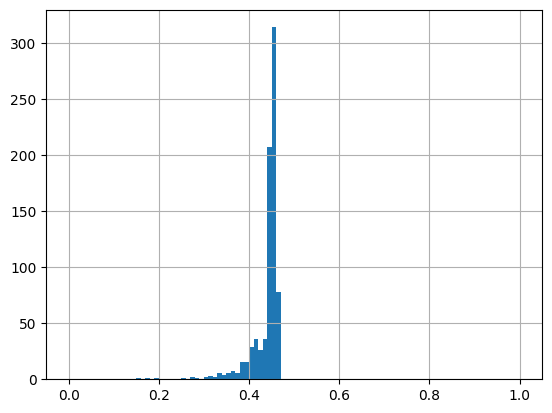

In [23]:
pd.Series(y_pred_prob[:, 0]).hist(bins=100, range=(0,1))